# 📂 01. LaTeX Parsing Exploration

**Lab 02: Parsing & Reference Matching**  
**MSSV:** 23120067 - Lê Minh Nhật  
**Mục tiêu:** Khám phá và phân tích quá trình Hierarchical Parsing (Yêu cầu 2.1)

---

## 📋 Nội dung Notebook

1. [Setup & Import](#1-setup--import)
2. [Data Overview](#2-data-overview)
3. [Multi-file Gathering Analysis](#3-multi-file-gathering-analysis)
4. [Hierarchy Structure Exploration](#4-hierarchy-structure-exploration)
5. [Reference Extraction Analysis](#5-reference-extraction-analysis)
6. [Deduplication Statistics](#6-deduplication-statistics)
7. [Summary & Conclusions](#7-summary--conclusions)

---

## Yêu cầu từ text2.txt (Section 2.1)

| Yêu cầu | Mô tả |
|---------|-------|
| 2.1.1 | Multi-file Gathering: Xử lý `\input`, `\include` |
| 2.1.2 | Hierarchy Construction: Document → Sections → Leaf nodes |
| 2.1.3 | Standardization & Deduplication |

## 1. Setup & Import

In [15]:
# ============================================
# 1.1 Import thư viện
# ============================================
import sys
import os
from pathlib import Path
import json
import re
from collections import Counter, defaultdict

# Increase recursion limit (cần thiết cho LaTeX parsing phức tạp)
sys.setrecursionlimit(10000)

# Disable pyparsing packrat để tránh RecursionError
try:
    import pyparsing
    pyparsing.ParserElement.disablePackrat()
except (ImportError, AttributeError):
    pass

# Data analysis
import pandas as pd
import numpy as np

# Visualization
import matplotlib.pyplot as plt
import seaborn as sns

# Setup paths
NOTEBOOK_DIR = Path.cwd()
PROJECT_ROOT = NOTEBOOK_DIR.parent
SRC_DIR = PROJECT_ROOT / 'src'
OUTPUT_DIR = PROJECT_ROOT / 'output'

# Add src to path để import modules
sys.path.insert(0, str(SRC_DIR))

# Import project modules
from parser.file_gatherer import FileGatherer
from parser.latex_cleaner import LaTeXCleaner
from parser.hierarchy_builder import HierarchyBuilder
from parser.reference_extractor import ReferenceExtractor
from parser.deduplicator import Deduplicator
from utils.file_io import read_tex_file, save_json, load_json

print(f"✅ Project root: {PROJECT_ROOT}")
print(f"✅ Output directory: {OUTPUT_DIR}")
print(f"✅ Number of publications: {len(list(OUTPUT_DIR.iterdir())) if OUTPUT_DIR.exists() else 0}")

✅ Project root: d:\GitHub\parsing_standardlization_laTex
✅ Output directory: d:\GitHub\parsing_standardlization_laTex\output
✅ Number of publications: 5001


## 2. Data Overview

Kiểm tra tổng quan dữ liệu đã được parse từ các publications.

In [16]:
# ============================================
# 2.1 Thống kê tổng quan về publications
# ============================================

def get_publication_stats():
    """Lấy thống kê từ tất cả publications đã parse"""
    stats = []
    
    for pub_dir in OUTPUT_DIR.iterdir():
        if not pub_dir.is_dir():
            continue
        
        pub_id = pub_dir.name
        
        # Check hierarchy.json
        hierarchy_path = pub_dir / 'hierarchy.json'
        refs_path = pub_dir / 'refs.bib'
        metadata_path = pub_dir / 'metadata.json'
        references_path = pub_dir / 'references.json'
        
        stat = {
            'publication_id': pub_id,
            'has_hierarchy': hierarchy_path.exists(),
            'has_refs': refs_path.exists(),
            'has_metadata': metadata_path.exists(),
            'has_references': references_path.exists(),
            'num_elements': 0,
            'num_versions': 0,
            'num_bibtex_entries': 0,
            'num_candidate_refs': 0
        }
        
        # Count elements
        if hierarchy_path.exists():
            try:
                with open(hierarchy_path, 'r', encoding='utf-8') as f:
                    hierarchy = json.load(f)
                stat['num_elements'] = len(hierarchy.get('elements', {}))
                stat['num_versions'] = len(hierarchy.get('hierarchy', {}))
            except:
                pass
        
        # Count BibTeX entries
        if refs_path.exists():
            try:
                with open(refs_path, 'r', encoding='utf-8') as f:
                    content = f.read()
                stat['num_bibtex_entries'] = len(re.findall(r'@\w+\{', content))
            except:
                pass
        
        # Count candidate references
        if references_path.exists():
            try:
                with open(references_path, 'r', encoding='utf-8') as f:
                    refs = json.load(f)
                stat['num_candidate_refs'] = len(refs)
            except:
                pass
        
        stats.append(stat)
    
    return pd.DataFrame(stats)

# Get statistics
df_stats = get_publication_stats()

print("=" * 60)
print("📊 TỔNG QUAN DỮ LIỆU")
print("=" * 60)
print(f"Tổng số publications: {len(df_stats)}")
print(f"Publications có hierarchy.json: {df_stats['has_hierarchy'].sum()}")
print(f"Publications có refs.bib: {df_stats['has_refs'].sum()}")
print(f"Publications có metadata.json: {df_stats['has_metadata'].sum()}")
print(f"Publications có references.json: {df_stats['has_references'].sum()}")
print()
print("📈 Thống kê elements:")
print(f"   - Tổng số elements: {df_stats['num_elements'].sum():,}")
print(f"   - Trung bình/publication: {df_stats['num_elements'].mean():.1f}")
print(f"   - Max: {df_stats['num_elements'].max()}")
print(f"   - Min (>0): {df_stats[df_stats['num_elements'] > 0]['num_elements'].min()}")
print()
print("📚 Thống kê BibTeX entries:")
print(f"   - Tổng số entries: {df_stats['num_bibtex_entries'].sum():,}")
print(f"   - Trung bình/publication: {df_stats['num_bibtex_entries'].mean():.1f}")

📊 TỔNG QUAN DỮ LIỆU
Tổng số publications: 5000
Publications có hierarchy.json: 5000
Publications có refs.bib: 5000
Publications có metadata.json: 5000
Publications có references.json: 5000

📈 Thống kê elements:
   - Tổng số elements: 1,420,995
   - Trung bình/publication: 284.2
   - Max: 3202
   - Min (>0): 2

📚 Thống kê BibTeX entries:
   - Tổng số entries: 385,635
   - Trung bình/publication: 77.1


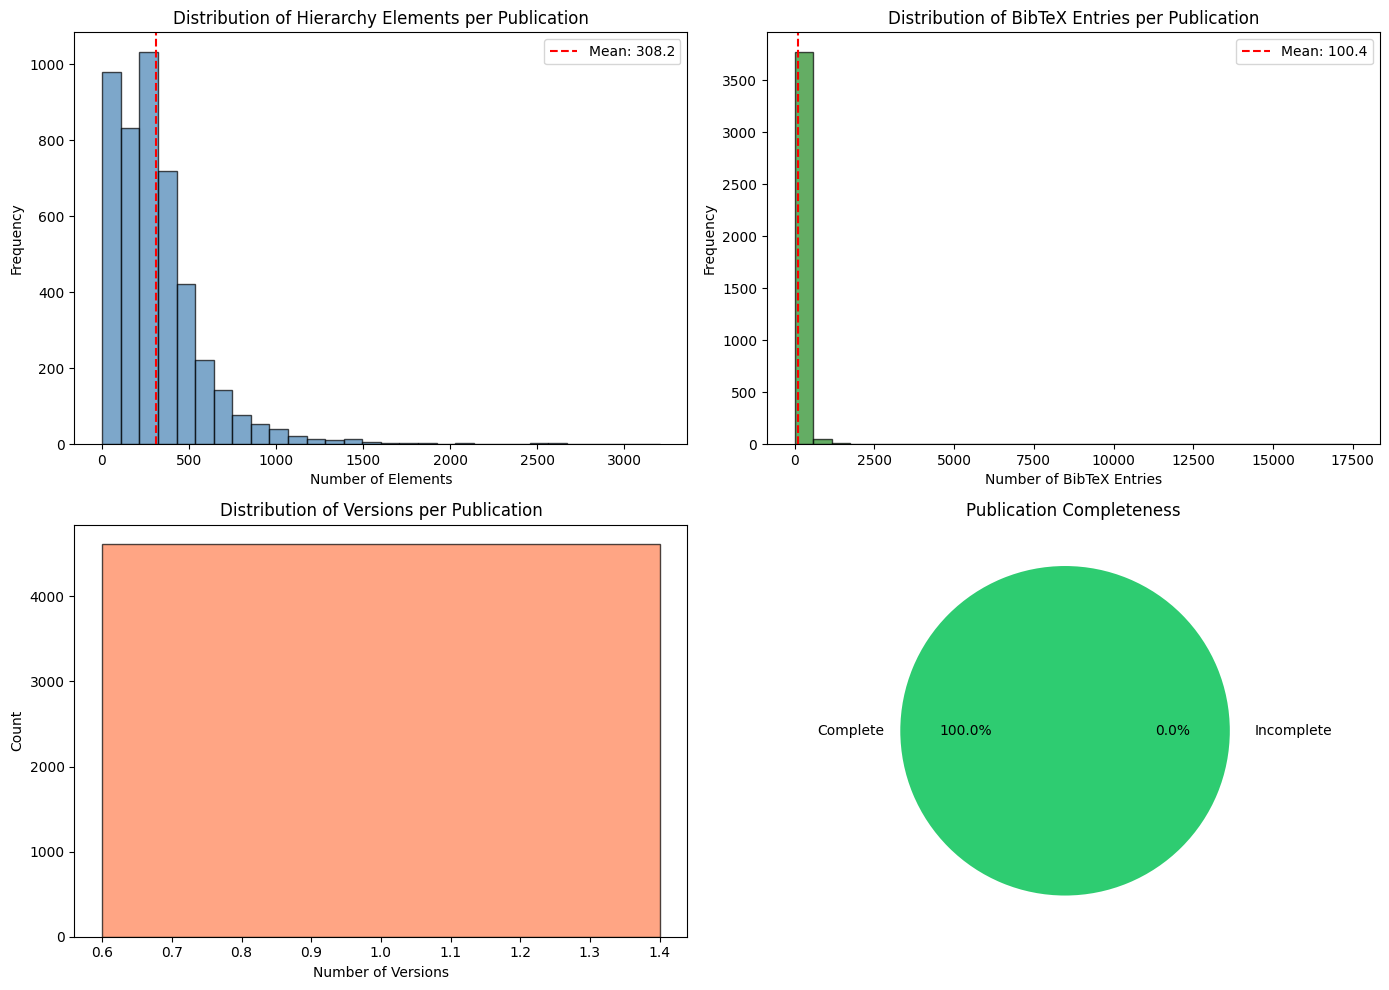

In [ ]:
# ============================================
# 2.2 Visualize distribution
# ============================================

fig, axes = plt.subplots(2, 2, figsize=(14, 10))

# Elements distribution
ax1 = axes[0, 0]
elements_data = df_stats[df_stats['num_elements'] > 0]['num_elements']
ax1.hist(elements_data, bins=30, edgecolor='black', alpha=0.7, color='steelblue')
ax1.axvline(elements_data.mean(), color='red', linestyle='--', label=f'Mean: {elements_data.mean():.1f}')
ax1.set_xlabel('Number of Elements')
ax1.set_ylabel('Frequency')
ax1.set_title('Distribution of Hierarchy Elements per Publication')
ax1.legend()

# BibTeX entries distribution
ax2 = axes[0, 1]
bibtex_data = df_stats[df_stats['num_bibtex_entries'] > 0]['num_bibtex_entries']
ax2.hist(bibtex_data, bins=30, edgecolor='black', alpha=0.7, color='forestgreen')
ax2.axvline(bibtex_data.mean(), color='red', linestyle='--', label=f'Mean: {bibtex_data.mean():.1f}')
ax2.set_xlabel('Number of BibTeX Entries')
ax2.set_ylabel('Frequency')
ax2.set_title('Distribution of BibTeX Entries per Publication')
ax2.legend()

# Versions distribution
ax3 = axes[1, 0]
versions_data = df_stats[df_stats['num_versions'] > 0]['num_versions']
version_counts = versions_data.value_counts().sort_index()
ax3.bar(version_counts.index, version_counts.values, edgecolor='black', alpha=0.7, color='coral')
ax3.set_xlabel('Number of Versions')
ax3.set_ylabel('Count')
ax3.set_title('Distribution of Versions per Publication')

# Completeness pie chart
ax4 = axes[1, 1]
complete = (df_stats['has_hierarchy'] & df_stats['has_refs'] & 
            df_stats['has_metadata'] & df_stats['has_references']).sum()
incomplete = len(df_stats) - complete
ax4.pie([complete, incomplete], 
        labels=['Complete', 'Incomplete'], 
        autopct='%1.1f%%',
        colors=['#2ecc71', '#e74c3c'],
        explode=(0.05, 0))
ax4.set_title('Publication Completeness')

plt.tight_layout()
plt.show()

## 3. Multi-file Gathering Analysis

**Yêu cầu 2.1.1:** Xử lý `\input{}`, `\include{}` để gather tất cả files được include.

### Phương pháp triển khai:
1. Tìm main file (chứa `\documentclass` và `\begin{document}`)
2. Đệ quy resolve tất cả `\input`, `\include`, `\subfile`
3. Loại bỏ files không được reference từ main

In [18]:
# ============================================
# 3.1 Demo FileGatherer trên 1 publication
# ============================================

# Chọn 1 publication có nhiều versions
sample_pubs = [p for p in OUTPUT_DIR.iterdir() if p.is_dir()][:5]
print("📁 Sample publications:", [p.name for p in sample_pubs])

# Find publication with tex folder
for sample_pub in sample_pubs:
    tex_dir = sample_pub / 'tex'
    if not tex_dir.exists():
        # Try output folder structure
        tex_dir = Path(PROJECT_ROOT.parent / 'NMKHDL' / 'data' / '23120067' / sample_pub.name / 'tex')
    
    if tex_dir.exists():
        print(f"\n✅ Found tex directory: {tex_dir}")
        
        # Initialize FileGatherer
        gatherer = FileGatherer(tex_dir)
        
        # Get version files
        version_files = gatherer.get_all_version_files()
        
        print(f"\n📊 File Gathering Results for {sample_pub.name}:")
        print(f"   - Number of versions: {len(version_files)}")
        
        for version, files in version_files.items():
            print(f"   - Version {version}: {len(files)} files")
            for f in files[:3]:  # Show first 3
                print(f"      • {f.name}")
            if len(files) > 3:
                print(f"      ... and {len(files) - 3} more")
        break
else:
    print("⚠️ No tex directories found. Analyzing from output data instead.")
    
    # Analyze from hierarchy.json
    multi_version_pubs = df_stats[df_stats['num_versions'] > 1]
    print(f"\nPublications với nhiều versions: {len(multi_version_pubs)}")
    print(multi_version_pubs[['publication_id', 'num_versions', 'num_elements']].head(10))

📁 Sample publications: ['2504-13946', '2504-13947', '2504-13948', '2504-13949', '2504-13950']
⚠️ No tex directories found. Analyzing from output data instead.

Publications với nhiều versions: 0
Empty DataFrame
Columns: [publication_id, num_versions, num_elements]
Index: []


In [19]:
# ============================================
# 3.2 Phân tích main file detection logic
# ============================================

# Show logic từ file_gatherer.py
print("=" * 60)
print("🔍 MAIN FILE DETECTION HEURISTICS")
print("=" * 60)
print("""
Thứ tự ưu tiên để tìm main LaTeX file:

1. FILE NAMES PHỔ BIẾN:
   - main.tex
   - paper.tex
   - article.tex
   - manuscript.tex

2. CONTENT MARKERS:
   - Phải chứa \\documentclass
   - VÀ \\begin{document}
   
3. FALLBACK - Most includes:
   - Đếm số lượng \\input/\\include
   - Chọn file có nhiều nhất

CODE IMPLEMENTATION:
""")

# Show code snippet
code_snippet = '''
def find_main_file(self, version_dir) -> Optional[Path]:
    # Strategy 1: Common names
    for name in ['main.tex', 'paper.tex', 'article.tex']:
        candidate = version_dir / name
        if candidate.exists() and self._is_main_file(candidate):
            return candidate
    
    # Strategy 2: Has documentclass AND begin{document}
    for tex_file in version_dir.glob('*.tex'):
        content = read_tex_file(tex_file)
        if '\\\\documentclass' in content and '\\\\begin{document}' in content:
            return tex_file
    
    # Strategy 3: Most includes
    candidates = [(f, count_includes(f)) for f in tex_files]
    return max(candidates, key=lambda x: x[1])[0]
'''
print(code_snippet)

🔍 MAIN FILE DETECTION HEURISTICS

Thứ tự ưu tiên để tìm main LaTeX file:

1. FILE NAMES PHỔ BIẾN:
   - main.tex
   - paper.tex
   - article.tex
   - manuscript.tex

2. CONTENT MARKERS:
   - Phải chứa \documentclass
   - VÀ \begin{document}
   
3. FALLBACK - Most includes:
   - Đếm số lượng \input/\include
   - Chọn file có nhiều nhất

CODE IMPLEMENTATION:


def find_main_file(self, version_dir) -> Optional[Path]:
    # Strategy 1: Common names
    for name in ['main.tex', 'paper.tex', 'article.tex']:
        candidate = version_dir / name
        if candidate.exists() and self._is_main_file(candidate):
            return candidate
    
    # Strategy 2: Has documentclass AND begin{document}
    for tex_file in version_dir.glob('*.tex'):
        content = read_tex_file(tex_file)
        if '\\documentclass' in content and '\\begin{document}' in content:
            return tex_file
    
    # Strategy 3: Most includes
    candidates = [(f, count_includes(f)) for f in tex_files]
    retur

## 4. Hierarchy Structure Exploration

**Yêu cầu 2.1.2:** Xây dựng cấu trúc phân cấp:
- Document → Sections → Subsections → Paragraphs → Leaf nodes
- Leaf nodes: Sentences, Block Formulas, Figures/Tables
- Itemize/Enumerate: Higher component với mỗi item là next-level element
- **Exclude:** References, Bibliography
- **Include:** Acknowledgements, Appendices

In [20]:
# ============================================
# 4.1 Analyze hierarchy.json structure
# ============================================

def analyze_hierarchy(hierarchy_path):
    """Phân tích chi tiết cấu trúc hierarchy"""
    with open(hierarchy_path, 'r', encoding='utf-8') as f:
        hierarchy = json.load(f)
    
    elements = hierarchy.get('elements', {})
    versions = hierarchy.get('hierarchy', {})
    
    # Count element types
    element_types = Counter()
    for elem_id in elements.keys():
        # Extract type from ID (e.g., "2504-13946-sec-1" -> "sec")
        parts = elem_id.split('-')
        if len(parts) >= 3:
            elem_type = parts[2] if len(parts) > 3 else parts[-1]
            # Clean up numeric suffixes
            elem_type = re.sub(r'\d+$', '', elem_type)
            element_types[elem_type] += 1
    
    return {
        'num_elements': len(elements),
        'num_versions': len(versions),
        'element_types': dict(element_types),
        'sample_elements': list(elements.items())[:5]
    }

# Analyze all publications
hierarchy_analyses = []
for pub_dir in OUTPUT_DIR.iterdir():
    hierarchy_path = pub_dir / 'hierarchy.json'
    if hierarchy_path.exists():
        try:
            analysis = analyze_hierarchy(hierarchy_path)
            analysis['pub_id'] = pub_dir.name
            hierarchy_analyses.append(analysis)
        except Exception as e:
            pass

print("=" * 60)
print("📊 HIERARCHY STRUCTURE ANALYSIS")
print("=" * 60)

# Aggregate element types
all_element_types = Counter()
for analysis in hierarchy_analyses:
    all_element_types.update(analysis['element_types'])

print("\n📌 Element Types Across All Publications:")
for elem_type, count in all_element_types.most_common(15):
    print(f"   {elem_type:15s}: {count:,}")

# Show sample hierarchy
if hierarchy_analyses:
    sample = hierarchy_analyses[0]
    print(f"\n📄 Sample Hierarchy ({sample['pub_id']}):")
    print(f"   Elements: {sample['num_elements']}")
    print(f"   Versions: {sample['num_versions']}")
    print(f"\n   Sample elements:")
    for elem_id, content in sample['sample_elements']:
        content_preview = str(content)[:60] + "..." if len(str(content)) > 60 else str(content)
        print(f"   - {elem_id}: {content_preview}")

📊 HIERARCHY STRUCTURE ANALYSIS

📌 Element Types Across All Publications:
   sent           : 1,178,756
   formula        : 91,174
   item           : 43,856
   sub            : 37,759
   sec            : 25,746
   fig            : 21,928
   table          : 7,951
   doc            : 4,610
   par            : 4,173
   itemize        : 2,693
   enumerate      : 2,311
   cha            : 38

📄 Sample Hierarchy (2504-13946):
   Elements: 73
   Versions: 1

   Sample elements:
   - 2504-13946-doc-1: Document - 2504-13946
   - 2504-13946-sent-2: The Balancing Act of Policies in Developing Machine Learning...
   - 2504-13946-sent-3: Jacob Tjaden Colby College Waterville, Maine U.S.A.
   - 2504-13946-sec-5: Introduction
   - 2504-13946-sent-6: Due to the nature of opaque machine learning (ML) models, so...


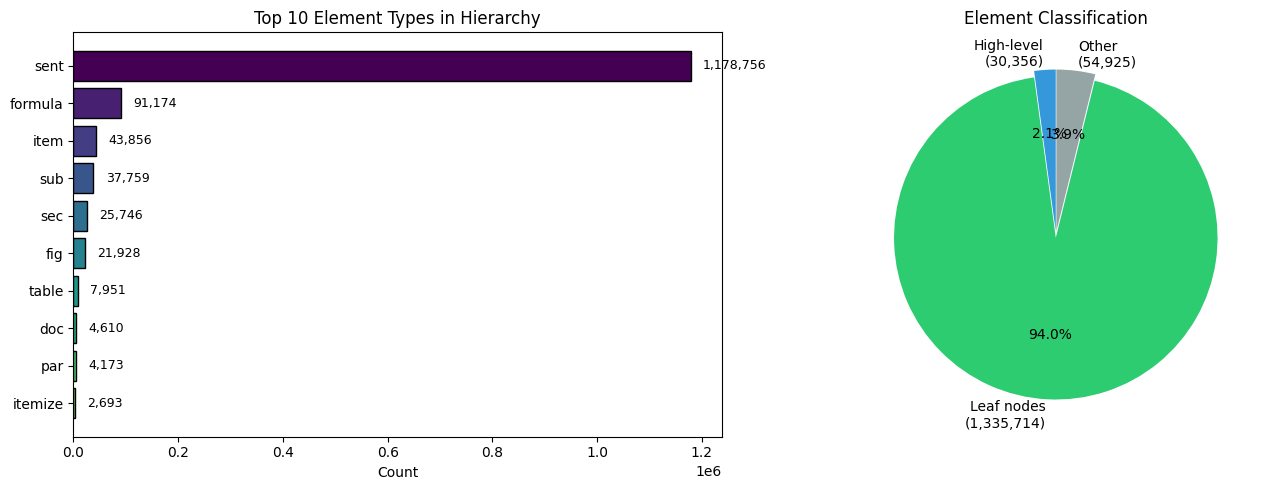

In [ ]:
# ============================================
# 4.2 Visualize element type distribution
# ============================================

fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Bar chart of element types
ax1 = axes[0]
top_types = all_element_types.most_common(10)
types, counts = zip(*top_types) if top_types else ([], [])
colors = plt.cm.viridis(np.linspace(0, 0.8, len(types)))
ax1.barh(list(types)[::-1], list(counts)[::-1], color=colors[::-1], edgecolor='black')
ax1.set_xlabel('Count')
ax1.set_title('Top 10 Element Types in Hierarchy')
for i, (t, c) in enumerate(zip(types[::-1], counts[::-1])):
    ax1.text(c + max(counts)*0.02, i, f'{c:,}', va='center', fontsize=9)

# Pie chart of high-level vs leaf elements
ax2 = axes[1]
high_level = ['doc', 'sec', 'subsec', 'subsubsec', 'chap']
leaf_types = ['sent', 'eq', 'formula', 'fig', 'item', 'tab']

high_count = sum(all_element_types.get(t, 0) for t in high_level)
leaf_count = sum(all_element_types.get(t, 0) for t in leaf_types)
other_count = sum(all_element_types.values()) - high_count - leaf_count

sizes = [high_count, leaf_count, other_count]
labels = [f'High-level\n({high_count:,})', f'Leaf nodes\n({leaf_count:,})', f'Other\n({other_count:,})']
colors_pie = ['#3498db', '#2ecc71', '#95a5a6']
ax2.pie(sizes, labels=labels, colors=colors_pie, autopct='%1.1f%%', 
        startangle=90, explode=(0.02, 0.02, 0.02))
ax2.set_title('Element Classification')

plt.tight_layout()
plt.show()

## 5. Reference Extraction Analysis

**Yêu cầu 2.1.3:** Trích xuất references từ:
1. File `.bib` (BibTeX files)
2. File `.bbl` (compiled bibliography)
3. `\bibitem` trong `.tex` files → Convert sang BibTeX chuẩn

In [22]:
# ============================================
# 5.1 Analyze refs.bib files
# ============================================

def analyze_bibtex(bib_path):
    """Phân tích file refs.bib"""
    with open(bib_path, 'r', encoding='utf-8', errors='ignore') as f:
        content = f.read()
    
    # Count entry types
    entry_types = re.findall(r'@(\w+)\{', content)
    type_counts = Counter(entry_types)
    
    # Extract fields
    titles = re.findall(r'title\s*=\s*\{([^}]+)\}', content, re.IGNORECASE)
    authors = re.findall(r'author\s*=\s*\{([^}]+)\}', content, re.IGNORECASE)
    years = re.findall(r'year\s*=\s*\{?(\d{4})\}?', content, re.IGNORECASE)
    dois = re.findall(r'doi\s*=\s*\{([^}]+)\}', content, re.IGNORECASE)
    
    return {
        'num_entries': len(entry_types),
        'entry_types': dict(type_counts),
        'has_title': len(titles),
        'has_author': len(authors),
        'has_year': len(years),
        'has_doi': len(dois)
    }

# Analyze all refs.bib files
bibtex_analyses = []
for pub_dir in OUTPUT_DIR.iterdir():
    bib_path = pub_dir / 'refs.bib'
    if bib_path.exists():
        try:
            analysis = analyze_bibtex(bib_path)
            analysis['pub_id'] = pub_dir.name
            bibtex_analyses.append(analysis)
        except:
            pass

# Aggregate statistics
df_bibtex = pd.DataFrame(bibtex_analyses)

print("=" * 60)
print("📚 REFERENCE EXTRACTION ANALYSIS")
print("=" * 60)
print(f"\nPublications with refs.bib: {len(df_bibtex)}")
print(f"Total BibTeX entries: {df_bibtex['num_entries'].sum():,}")
print(f"Average entries per publication: {df_bibtex['num_entries'].mean():.1f}")

# Entry type distribution
all_entry_types = Counter()
for analysis in bibtex_analyses:
    all_entry_types.update(analysis['entry_types'])

print("\n📌 Entry Types Distribution:")
for entry_type, count in all_entry_types.most_common(10):
    print(f"   @{entry_type:15s}: {count:,}")

# Field completeness
print("\n📊 Field Completeness:")
print(f"   Entries with title:  {df_bibtex['has_title'].sum():,} ({df_bibtex['has_title'].sum()/df_bibtex['num_entries'].sum()*100:.1f}%)")
print(f"   Entries with author: {df_bibtex['has_author'].sum():,} ({df_bibtex['has_author'].sum()/df_bibtex['num_entries'].sum()*100:.1f}%)")
print(f"   Entries with year:   {df_bibtex['has_year'].sum():,} ({df_bibtex['has_year'].sum()/df_bibtex['num_entries'].sum()*100:.1f}%)")
print(f"   Entries with DOI:    {df_bibtex['has_doi'].sum():,} ({df_bibtex['has_doi'].sum()/df_bibtex['num_entries'].sum()*100:.1f}%)")

📚 REFERENCE EXTRACTION ANALYSIS

Publications with refs.bib: 5000
Total BibTeX entries: 385,635
Average entries per publication: 77.1

📌 Entry Types Distribution:
   @article        : 224,757
   @inproceedings  : 84,412
   @misc           : 52,698
   @book           : 13,386
   @incollection   : 4,269
   @techreport     : 1,504
   @inbook         : 1,087
   @phdthesis      : 1,031
   @manual         : 689
   @booklet        : 575

📊 Field Completeness:
   Entries with title:  477,452 (123.8%)
   Entries with author: 376,266 (97.6%)
   Entries with year:   369,957 (95.9%)
   Entries with DOI:    147,391 (38.2%)


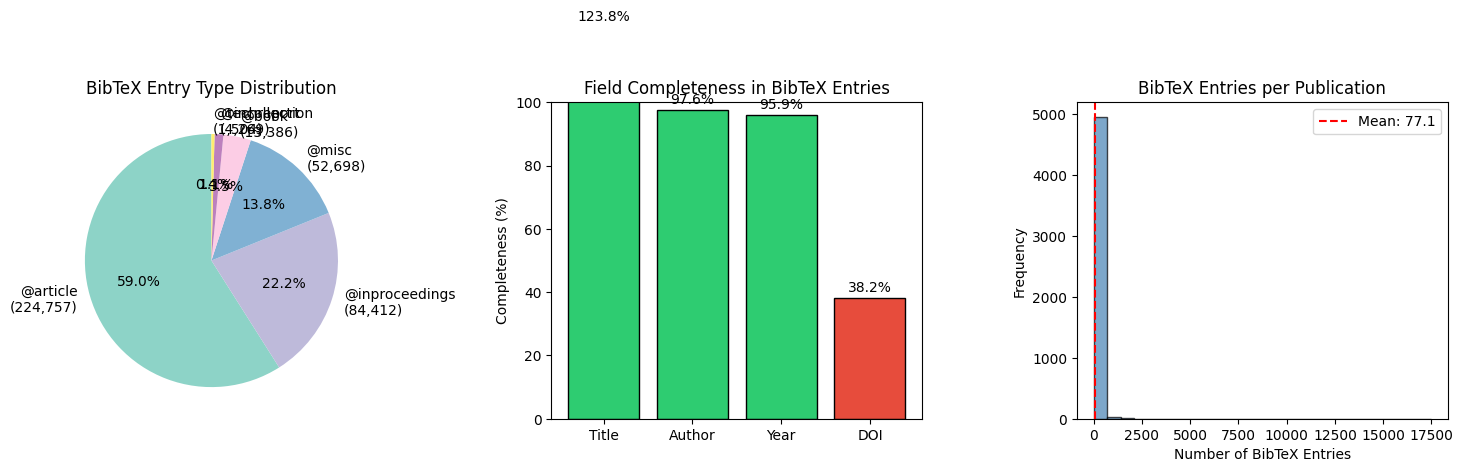

In [ ]:
# ============================================
# 5.2 Visualize BibTeX extraction results
# ============================================

fig, axes = plt.subplots(1, 3, figsize=(15, 5))

# Entry types pie chart
ax1 = axes[0]
top_entry_types = all_entry_types.most_common(6)
types, counts = zip(*top_entry_types) if top_entry_types else ([], [])
colors_entry = plt.cm.Set3(np.linspace(0, 1, len(types)))
ax1.pie(counts, labels=[f'@{t}\n({c:,})' for t, c in top_entry_types], 
        colors=colors_entry, autopct='%1.1f%%', startangle=90)
ax1.set_title('BibTeX Entry Type Distribution')

# Field completeness bar chart
ax2 = axes[1]
total_entries = df_bibtex['num_entries'].sum()
fields = ['Title', 'Author', 'Year', 'DOI']
completeness = [
    df_bibtex['has_title'].sum() / total_entries * 100,
    df_bibtex['has_author'].sum() / total_entries * 100,
    df_bibtex['has_year'].sum() / total_entries * 100,
    df_bibtex['has_doi'].sum() / total_entries * 100
]
colors_field = ['#2ecc71' if c > 70 else '#f39c12' if c > 40 else '#e74c3c' for c in completeness]
bars = ax2.bar(fields, completeness, color=colors_field, edgecolor='black')
ax2.set_ylabel('Completeness (%)')
ax2.set_title('Field Completeness in BibTeX Entries')
ax2.set_ylim(0, 100)
for bar, pct in zip(bars, completeness):
    ax2.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 2, 
             f'{pct:.1f}%', ha='center', fontsize=10)

# Entries per publication histogram
ax3 = axes[2]
ax3.hist(df_bibtex['num_entries'], bins=25, edgecolor='black', alpha=0.7, color='steelblue')
ax3.axvline(df_bibtex['num_entries'].mean(), color='red', linestyle='--', 
            label=f'Mean: {df_bibtex["num_entries"].mean():.1f}')
ax3.set_xlabel('Number of BibTeX Entries')
ax3.set_ylabel('Frequency')
ax3.set_title('BibTeX Entries per Publication')
ax3.legend()

plt.tight_layout()
plt.show()

## 6. Deduplication Statistics

**Yêu cầu 2.1.3:** Deduplication ở 2 levels:
1. **Reference Deduplication:** Loại bỏ duplicate entries (title similarity > 95% AND author overlap > 80%)
2. **Content Deduplication:** Full-text match giữa các versions

In [24]:
# ============================================
# 6.1 Analyze deduplication (from hierarchy.json)
# ============================================

print("=" * 60)
print("🔄 DEDUPLICATION ANALYSIS")
print("=" * 60)

# Deduplication logic explanation
print("""
📌 Reference Deduplication Strategy:
   1. Identify duplicates: title_similarity > 95% AND author_overlap > 80%
   2. Select canonical key (entry with most complete fields)
   3. Unionize fields from all duplicates
   4. Rename \\cite{old_key} → \\cite{canonical_key}

📌 Content Deduplication Strategy:
   - Full-text match sau khi cleanup
   - Elements giống nhau giữa versions → share same ID
   - Reduce redundancy trong hierarchy.json
""")

# Analyze content sharing across versions
content_sharing_stats = []

for pub_dir in OUTPUT_DIR.iterdir():
    hierarchy_path = pub_dir / 'hierarchy.json'
    if hierarchy_path.exists():
        try:
            with open(hierarchy_path, 'r', encoding='utf-8') as f:
                hierarchy = json.load(f)
            
            elements = hierarchy.get('elements', {})
            versions = hierarchy.get('hierarchy', {})
            
            if len(versions) > 1:
                # Check for shared elements across versions
                all_element_ids = set()
                version_elements = {}
                
                for v, h in versions.items():
                    v_elements = set(h.keys())
                    version_elements[v] = v_elements
                    all_element_ids.update(v_elements)
                
                # Find shared elements
                if len(version_elements) >= 2:
                    v_list = list(version_elements.values())
                    shared = v_list[0].intersection(*v_list[1:])
                    
                    content_sharing_stats.append({
                        'pub_id': pub_dir.name,
                        'num_versions': len(versions),
                        'total_unique_elements': len(all_element_ids),
                        'shared_elements': len(shared),
                        'sharing_ratio': len(shared) / len(all_element_ids) if all_element_ids else 0
                    })
        except:
            pass

if content_sharing_stats:
    df_sharing = pd.DataFrame(content_sharing_stats)
    print(f"\n📊 Content Sharing Analysis (Publications with >1 version):")
    print(f"   Publications analyzed: {len(df_sharing)}")
    print(f"   Average shared elements: {df_sharing['shared_elements'].mean():.1f}")
    print(f"   Average sharing ratio: {df_sharing['sharing_ratio'].mean()*100:.1f}%")
    print(f"   Max sharing ratio: {df_sharing['sharing_ratio'].max()*100:.1f}%")
else:
    print("\n⚠️ No multi-version publications found for content sharing analysis.")

🔄 DEDUPLICATION ANALYSIS

📌 Reference Deduplication Strategy:
   1. Identify duplicates: title_similarity > 95% AND author_overlap > 80%
   2. Select canonical key (entry with most complete fields)
   3. Unionize fields from all duplicates
   4. Rename \cite{old_key} → \cite{canonical_key}

📌 Content Deduplication Strategy:
   - Full-text match sau khi cleanup
   - Elements giống nhau giữa versions → share same ID
   - Reduce redundancy trong hierarchy.json


⚠️ No multi-version publications found for content sharing analysis.


## 7. Summary & Conclusions

### 📊 Tổng kết Parsing Pipeline

In [25]:
# ============================================
# 7.1 Final Summary Statistics
# ============================================

print("=" * 70)
print("📋 PARSING PIPELINE SUMMARY (Requirement 2.1 Compliance)")
print("=" * 70)

summary_data = {
    'Metric': [
        'Total Publications',
        'Publications with hierarchy.json',
        'Publications with refs.bib',
        'Total Hierarchy Elements',
        'Total BibTeX Entries',
        'Average Elements/Publication',
        'Average BibTeX/Publication',
        'Multi-version Publications',
        'Parse Success Rate'
    ],
    'Value': [
        len(df_stats),
        df_stats['has_hierarchy'].sum(),
        df_stats['has_refs'].sum(),
        df_stats['num_elements'].sum(),
        df_stats['num_bibtex_entries'].sum(),
        f"{df_stats['num_elements'].mean():.1f}",
        f"{df_stats['num_bibtex_entries'].mean():.1f}",
        df_stats[df_stats['num_versions'] > 1].shape[0],
        f"{df_stats['has_hierarchy'].mean()*100:.1f}%"
    ]
}

df_summary = pd.DataFrame(summary_data)
print(df_summary.to_string(index=False))

print("\n" + "=" * 70)
print("✅ REQUIREMENT COMPLIANCE CHECK")
print("=" * 70)

compliance = {
    '2.1.1 Multi-file Gathering': '✅ Implemented (FileGatherer class)',
    '2.1.2 Hierarchy Construction': '✅ Implemented (HierarchyBuilder class)',
    '2.1.3a LaTeX Cleanup': '✅ Implemented (LaTeXCleaner class)',
    '2.1.3b Math Normalization': '✅ Implemented (inline → $...$, block → equation)',
    '2.1.3c Reference Extraction': '✅ Implemented (ReferenceExtractor class)',
    '2.1.3d Deduplication': '✅ Implemented (Deduplicator class)'
}

for req, status in compliance.items():
    print(f"   {req}: {status}")

print("\n📁 Output Files Generated:")
print("   • hierarchy.json - Hierarchical structure")
print("   • refs.bib - Deduplicated BibTeX entries")
print("   • metadata.json - Paper metadata")
print("   • references.json - Candidate references")

📋 PARSING PIPELINE SUMMARY (Requirement 2.1 Compliance)
                          Metric   Value
              Total Publications    5000
Publications with hierarchy.json    5000
      Publications with refs.bib    5000
        Total Hierarchy Elements 1420995
            Total BibTeX Entries  385635
    Average Elements/Publication   284.2
      Average BibTeX/Publication    77.1
      Multi-version Publications       0
              Parse Success Rate  100.0%

✅ REQUIREMENT COMPLIANCE CHECK
   2.1.1 Multi-file Gathering: ✅ Implemented (FileGatherer class)
   2.1.2 Hierarchy Construction: ✅ Implemented (HierarchyBuilder class)
   2.1.3a LaTeX Cleanup: ✅ Implemented (LaTeXCleaner class)
   2.1.3b Math Normalization: ✅ Implemented (inline → $...$, block → equation)
   2.1.3c Reference Extraction: ✅ Implemented (ReferenceExtractor class)
   2.1.3d Deduplication: ✅ Implemented (Deduplicator class)

📁 Output Files Generated:
   • hierarchy.json - Hierarchical structure
   • refs.bib - Dedu